In [1]:
import os
import numpy as np
import tensorflow_probability as tfp
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
mnist2 = input_data.read_data_sets('MNIST_data/')

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


In [115]:
mnist2.test.images[0]
len(mnist2.test.images)
len(mnist2.test.images[0])

784

In [114]:
mnist2.test.labels
len(mnist2.test.labels)

10000

In [90]:
tfd = tfp.distributions
input_size = 28 * 28
params = {
    'latent_dim': 2,
    'decoder_std': 0.5
}

decoder_std = 0.5
epochs = 10
batch_size = 128

In [104]:
class VAE(object):
    def __init__(self, learning_rate=0.001, decoder_std = 0.5, latent_dim=2):
        #set hyperparameters
        self.x = tf.placeholder(dtype=tf.float32, shape=[None, input_size])
        self.learning_rate = learning_rate
        self.decoder_std = decoder_std
        self.latent_dim = latent_dim
        
        self.build()
        
        #Initialize parameters
        self.sess = tf.Session()
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
    def encoder(self, x):
        x1 = tf.layers.dense(x, 256, activation=tf.nn.relu)
        x2 = tf.layers.dense(x1, 256, activation=tf.nn.relu)
        self.mu = tf.layers.dense(x2, self.latent_dim)
        self.scale = tf.layers.dense(x2, self.latent_dim)
        std = tf.sqrt(1e-5 + tf.exp(self.scale))
        return self.mu, std
    
    def prior(self):
        loc = tf.zeros(self.latent_dim)
        scale = tf.ones(self.latent_dim)
        return tfd.MultivariateNormalDiag(loc, scale)
    
    def decoder(self, z, input_size=28*28): #input_size=784
        z1 = tf.layers.dense(z, 256, activation=tf.nn.relu)
        z2 = tf.layers.dense(z1, 256, activation=tf.nn.relu)
        mu = tf.layers.dense(z2, input_size)
        self.decoder_std = tf.layers.dense(z2, input_size, activation=tf.nn.softplus)
        return mu
    
    def build(self):

        #encode an image into the distribution of latent space
        self.encoder_mu, self.encoder_std = self.encoder(self.x)

        #sample by reparametrisation
        eps = tf.random_normal(shape=[tf.shape(self.x)[0], self.latent_dim], mean=0.0, stddev=1.0, dtype=tf.float32)
        self.z = self.encoder_mu + self.encoder_std*eps

        #decode latent vector z
        decoder_mu = self.decoder(self.z)
        
        posterior = tfd.MultivariateNormalDiag(self.encoder_mu, self.scale)
        prior = self.prior()
        
        self.samples = tfd.MultivariateNormalDiag(self.decoder(prior.sample(15)), self.decoder_std).mean()
        #reconstruction loss
        self.likelihood = -tf.reduce_sum(tfd.Normal(decoder_mu, decoder_std).log_prob(self.x),axis=1)
        
        #KL divergence loss
        #self.divergence = -0.5 * tf.reduce_sum(
        #    1 + tf.log(tf.square(self.encoder_std)) - self.encoder_mu ** 2 - tf.square(self.encoder_std),
        #    axis=1)
        self.divergence = tfd.kl_divergence(posterior, prior)
        self.elbo = tf.reduce_mean(self.likelihood + self.divergence, axis=0)
        self.optimize = tf.train.AdamOptimizer(self.learning_rate).minimize(self.elbo)
        return

    def run(self, x):
        self.sess.run(self.optimize, feed_dict={self.x: x})
        return
    
    
    def plot_codes(ax, z, labels):
        ax.scatter(z[:, 0], z[:, 1], s=2, c=labels, alpha=0.1)
        ax.set_aspect('equal')
        ax.set_xlim(z.min() - .1, z.max() + .1)
        ax.set_ylim(z.min() - .1, z.max() + .1)
        ax.tick_params(
            axis='both', which='both', left='off', bottom='off',
            labelleft='off', labelbottom='off')    
 

Epoch 0 elbo 363.628
Epoch 1 elbo 263.19724
Epoch 2 elbo 258.23697
Epoch 3 elbo 256.1545
Epoch 4 elbo 255.0491
Epoch 5 elbo 254.6153
Epoch 6 elbo 253.6613
Epoch 7 elbo 253.07907
Epoch 8 elbo 252.9418
Epoch 9 elbo 252.49718


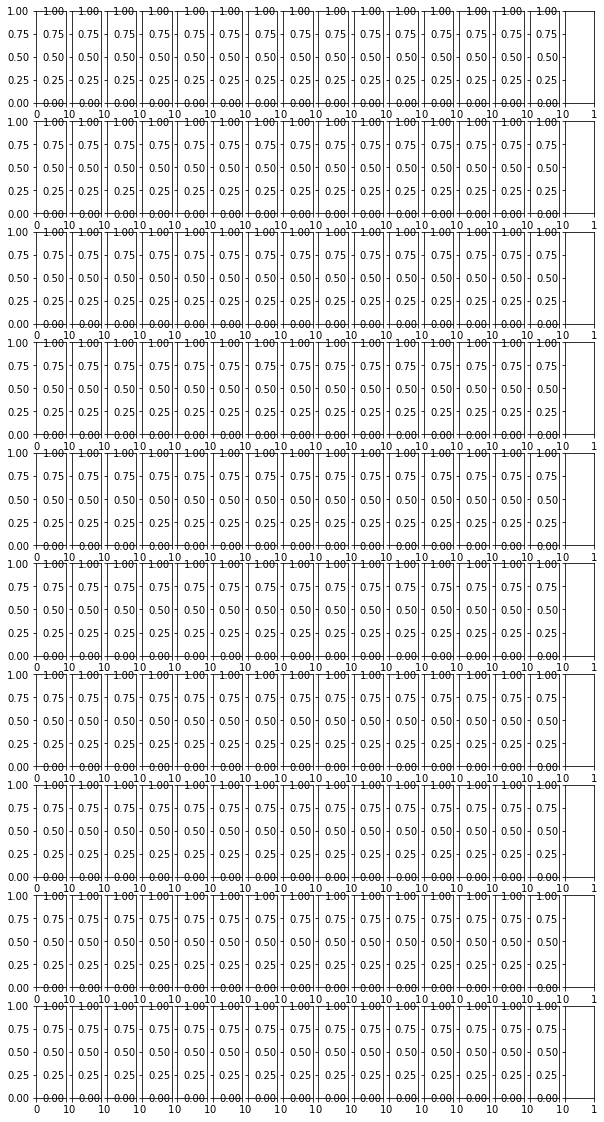

In [105]:
model = VAE(learning_rate=0.001, decoder_std=0.5, latent_dim= params['latent_dim'])
#fig, ax = plt.subplots(nrows=10, ncols=16, figsize=(10, 20))

for epoch in range(epochs):
    feed = {model.x: mnist2.test.images}
    test_elbo, test_z, test_samples =  model.sess.run([model.elbo, model.z, model.samples], feed)
    print('Epoch', epoch, 'elbo', test_elbo)
    
    #plot latent representation
    #while epoch == 5:
        #ax[epoch, 0].set_ylabel('Epoch {}'.format(epoch))
        #model.plot_codes(ax[epoch, 0], test_z, mnist2.test.labels)
    
    for _ in range(mnist2.train.num_examples // batch_size):
        batch = mnist2.train.next_batch(batch_size)[0]
        model.run(batch)